# Decision Trees

In this activity we will introduce the concept of decision tree classifiers and discuss their properties.

## Contents

* Introduction
* Wine Data
* Decision Trees
* Overfitting
* Exercises

## Introduction

The advantages and disadvantages of decision trees are:
* Advantages
    * They are easy to interpret and visualize. You ask a series of questions, and the answers to those 
      questions leads to the classification of the target variables.
    * They can be used for classification and regression, though we only consider classification here.
    * The algorithm can easily deal with categorical and continuous feature variables.
    * Decision trees can easily capture nonlinear patterns.
    * They require less data preprocessing from the user, for example, there is no need to normalize columns.
    * They can be used for feature engineering such as predicting missing values and variable selection.
* Disadvantages
    * Decision trees are sensitive to noisy data, and can easily overfit noisy data.
    * A small variance in data can result in significantly different decision tree. This can be reduced by 
      running an ensemble of decision trees (random forests), and using bagging and boosting algorithms.
    * Decision trees are biased with imbalanced datasets, where there is only a small proportion of samples in a 
      particular category. So it is recommended to balance the dataset before creating the decision tree.

First we introduce the necessary libraries.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

We also define some of our own functions to use for displaying the results of the methods. To view the explanation and syntax for these functions, use `help()`.

In [4]:
from logitplots import plt_confusion_matrix, plt_decision_boundaries, plt_correlation_matrix

## Wine Data

For this activity we use the Wine Classification dataset from the UCI Machine Learning archive (https://archive.ics.uci.edu/ml/datasets/Wine). This is an analysis from 1991 of 178 different wines from a region of Italy. The analysis considers three cultivars (grape varieties) and analyses 13 chemical and physical properties of the wines. These properties are:
* Alcohol: alcohol content, reported in units of ABV (alcohol by volume).
* Malic acid: one of the principal organic acids found in wine.
* Ash: the inorganic matter left after evaporation and incineration.
* Alcalinity [sic] of ash: the alkalinity of ash determines how basic (as opposed to acidic) the ash in a wine is.
* Magnesium: magnesium is a metal that affects the flavor of wine.
* Total phenols: Phenols are chemicals that affect the taste, color, and mouthfeel (i.e., texture) of wine.
* Flavoids [sic]: flavonoids are a type of phenol.
* Nonflavoid [sic] phenols: nonflavonoids are another type of phenol.
* Proanthocyanins [sic]: proanthocyanidins are yet another type of phenol.
* Color intensity: the color intensity of a wine: i.e., how dark it is.
* Hue: the hue of a wine, which is typically determined by the color of the cultivar used.
* OD280/OD315 of diluted wines: protein content measurements.
* Proline: an amino acid present in wines.

We first read in the data set, and give appropriate names to the columns of the dataframe. The first column is the classification (cultivar) of that wine.

In [5]:
df = pd.read_csv("wine_data.csv", header = None,
                 names = ['Class','Alcohol','MalicAcid','Ash','Alcalinity','Mg',
                            'Phenols','Flavanoids','Nonflavanoids','Proanthocyanins',
                            'Colour','Hue','ProteinConcentration','Proline'])
df.head() # display the first few rows of the dataframe

,Class,Alcohol,MalicAcid,Ash,Alcalinity,Mg,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Colour,Hue,ProteinConcentration,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### EDA

Before attempting any modelling, we undertake some exploratory data analysis. First step is to check whether there are any missing values. These will be indicated by the type for that column being an `object`. In this case there are only integer and floating point values, which suggests there are no missing values.

In [6]:
df.dtypes # check for missing data, which would be indicated by type being an object

Class                     int64
Alcohol                 float64
MalicAcid               float64
Ash                     float64
Alcalinity              float64
Mg                        int64
Phenols                 float64
Flavanoids              float64
Nonflavanoids           float64
Proanthocyanins         float64
Colour                  float64
Hue                     float64
ProteinConcentration    float64
Proline                   int64
dtype: object

We can confirm this by checking if any values of the dataframe are null (NaN). The result is false, so no missing values.

In [7]:
df.isnull().values.any() # check if there are any True values for the test isnull on the dataframe

False

Missing values could also be specified by a very large positive or negative number. As a further check we look at the descriptive statistics to see if there is anything unusual. Again everything looks clean.

In [8]:
df.describe() # display the descriptive statistics for numerical values of the dataframe

,Class,Alcohol,MalicAcid,Ash,Alcalinity,Mg,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Colour,Hue,ProteinConcentration,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Finally we investigate the correlation matrix, to try to determine any relationships between the feature variables. Since the target variable is a classification, correlation is not relevant for this variable. The matrix shows that there is a significant correlation between `Flavanoids`, `ProteinConcentration` and `Phenols`. Therefore using any combination of these three features in a model may cause multicollinearity problems.

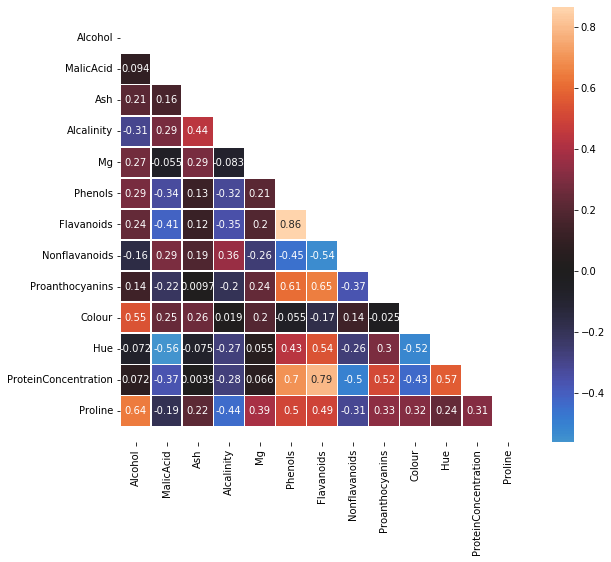

In [9]:
corrs = df.drop('Class', axis = 1).corr() # calculate the correlation table, first dropping the Class column
plt_correlation_matrix(corrs) # plot the correlation matrix

## Decision Trees

A Decision Tree is comprised of *nodes*, *branches* and *leafs*. A *node* on the tree is a point at which a branching decision is made on a particular group of samples of the original population. This branching decision then produces two child nodes, which could be another node or a *leaf node*. A *leaf node* or *leaf* is a node which does not have any child nodes. For example, if the samples for a node only have a single target value, then there is no need to branch that population further and the tree terminates at that node. The *depth* of the decision tree corresponds to how many branches have been traversed from the original training set. The original training set has `depth=0`, and the nodes immediately below that have `depth=1`. As we go deeper down the tree the number of nodes increases. Without any leaves, the number of nodes at `depth=n` will be $2^n$.

To understand how the Decision Tree Classifier makes a branching decision at a particular node, we need to introduce the `gini` score for a node. This measures the impurity of the target samples at that node. If `gini=0` then we have only one target value at that node, and the node is *pure*. Therefore this node becomes a *leaf* and the decision tree terminates. If there is a mixture of target samples at that node then `gini > 0` and the node is regarded as *impure*. Consider that at this node we have $m$ samples, and $n$ target values or classes. For the target value $j$, we have $m_j$ samples, and the proportion of $j$ samples is $p_j = m_j/m$. Then the `gini` score is defined as 

$$ G = 1-(p_1^2+p_2^2+\cdots+p_n^2). $$

This is always greater than or equal to zero, and is only zero if the proportion is one for one particular class, and therefore zero for all other classes.

At a particular node the branching decision is now made by splitting the samples based on a threshold $t_k$ for feature $k$. Let the value of feature $k$ be $v_k$, then if $v_k \le t_k$ that sample branches to the left child node, and otherwise the sample branches to the right child node. For all features $k$ the algorithm then searches over all thresholds $t_k$, such that weighted gini score

$$ J(k,t_k) = \frac{m_{{\rm left}}}{m} G_{{\rm left}} + \frac{m_{{\rm right}}}{m} G_{{\rm right}}, $$

is minimized. The subscript `left` and `right` refer to the values for the left and right child nodes. This ensures the purest splitting of the sample to the two child nodes.

`Entropy` or `Information Gain` can also be used to determine the branching process, which sometimes can give differing results. Entropy for a dataset is defined as

$$ E = -(p_1\log_2 p_1 + p_2\log_2 p_2 + \cdots +p_n \log_2 p_n). $$

### Creating modelling dataframes

We now create the necessary dataframes to undertaken modelling using Decision Trees. We drop the classification to create a dataframe of features `X`, and use the classification to create a target dataframe `y`. These are then split into testing and training sets. For Decision Trees there is no need to preprocess the data using sorting or normalization. However, we do have to be careful about balance of the labels in the datasets.

In [10]:
X = df.drop('Class', axis = 1) # create a dataframe of features, by dropping the target variable
y = df['Class'] # create a dataframe of target values
# split the dataframes into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

We can now instantatiate and train our model. This is done in the same way as for other `sklearn` models.

In [11]:
# instantatiate the DTC, set random_state so results are repeatable
df_dtc = DecisionTreeClassifier(random_state = 42) 
df_dtc = df_dtc.fit(X_train, y_train) # train the model using the training set

We can now investigate the Decision Tree by using the `plot_tree` function. At each node which is not a leaf, the plot shows the branching criteria, the gini score, the number of samples at that node, the number of samples for each target value and the class with the highest proportion. The nodes are then coloured in proportion to values for each class. For leaf nodes the same values are shown without the branching criteria. In this case leaf nodes have gini=0 and are coloured purely with the chosen colour for that class. In the example below, Class 1 is coloured orange, Class 2 is green and Class 3 is purple. For the Wine Classification problem the only features that are used are `Alcohol` , `Ash`, `Flavanoids`, `Colour` and `Proline`. 

Consider the classification at the root node (depth=0). In this case, splitting `Colour` at the value of 3.82 largely divides Class 2 from the other two classes. For the left child node the gini score is very low, which contributes to the minimization of $J(k,t_k)$.

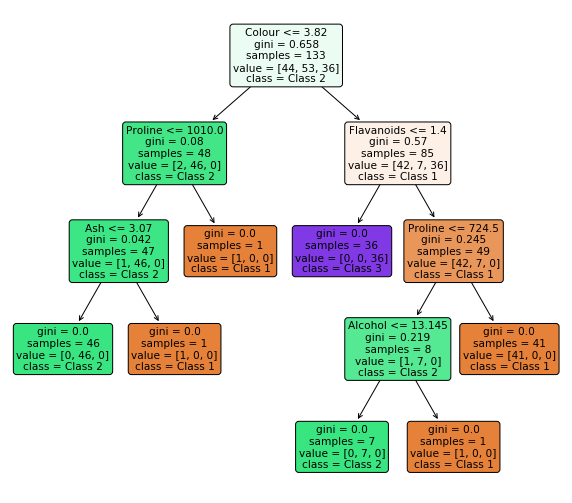

In [12]:
fig, ax = plt.subplots(figsize=(10,9)) # initialise the plots and axes
# plot the decision tree for the model df_dtc
plot_tree(df_dtc, 
 filled = True, # colour the nodes according to the classifaction
 rounded = True, # make the nodes have rounded corners
 class_names = ['Class 1', 'Class 2','Class 3'], # use these names for targets
 feature_names = X.columns # use these names for features
 );

The prediction process for the decision tree is very simple. For each test sample the appropriate feature is tested at each node and the tree is traversed until a leaf or the bottom of the tree is reached. The target value given for that sample is then the target value of the leaf. 

As this is a multinomial classification problem, we can again use the `confusion matrix` and `accuracy score` to test the accurary of the classifier. Here the Decision Tree Classifier gives a very impressive accuracy of 95.6%, with only 2 false classifications for the training set.

Decision Tree Accuracy: 0.956


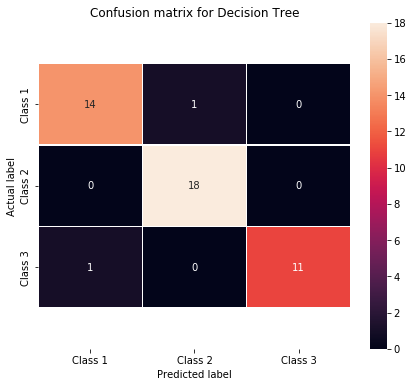

In [13]:
Y_pred = df_dtc.predict(X_test) # calculate the predictions of the model for our test set
# plot the confusion matrix for the test and predicted target values
cm = confusion_matrix(y_test, Y_pred)
plt_confusion_matrix(cm, ['Class 1','Class 2','Class 3'], 'Decision Tree') 
print("Decision Tree Accuracy:",np.round(accuracy_score(y_test, Y_pred),3)) # calculate and print the accuracy score

To understand the Decision Tree Classifier further, we can introduce a two feature model for the Wine Classification. The two features we choose, which appear near to the top of the decision tree, are  `Flavanoids` and `Proline`. 

First we create create a new data frame with only the categories `Class`, `Flavanoids` and `Proline`, and then split this into data frames with the feature values and targets values. This can then be plotted as a scatter plot, based on the three categories. By comparing this with the previous decision tree plot, we can identify the yellow plots as Class 3, the green dots as Class 2 and the purple dots as Class 1.

Text(0, 0.5, 'Proline')

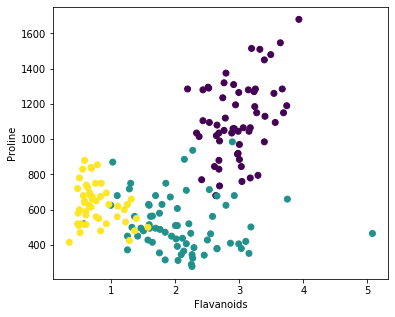

In [14]:
X = df[['Flavanoids','Proline']] # drop the target variable for the features
y = df['Class'] # create a target dataframe
fig, ax = plt.subplots(figsize=(6,5)) # initialise the plots and axes
plt.scatter(X['Flavanoids'], X['Proline'], c=y); # scatter plot of the two features, coloured based on the target
plt.xlabel('Flavanoids') # xlabel
plt.ylabel('Proline') # ylabel

We now split our data into training and testing sets.

In [15]:
# split the dataframes into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

To visualize the decision tree process, we investigate the evolution of the decision tree as we change the maximum depth that the Decision Tree Classifier, but keep all other parameters constant, including the random seed. The maximum depth is specified via the parameter `max_depth`. At depth=1 the feature space is split on the `Proline` feature, then at the next level each of the two regions can be split on different values of the `Flavanoids` feature. This results in a combined region for Class 3, although the Decision Tree Classifier records them as separate regions. After this the regions can be split either vertically or horizontally.

Note that the maximum accuracy occurs for depth=3.

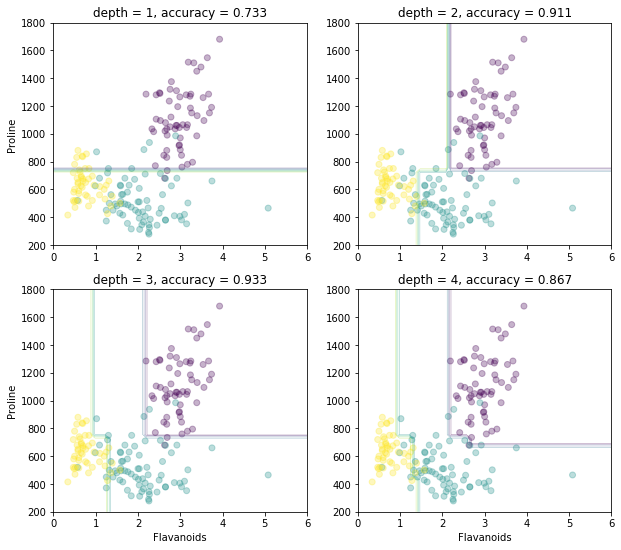

In [16]:
fig, axs = plt.subplots(2,2,figsize=(10,9)) # initialise the plots and axes for a 2x2 set of plots
# create arrays for contour plots of the decision boundaries
xx, yy = np.meshgrid(np.linspace(0,6), np.linspace(200,1800))
for i in range(2): # i loops over (0,1)
    for j in range(2): # j loops over (0,1)
        depth = i*2+j+1 # depth can then be calculated based on i and j
        # fit the data to our DTC and specify the maximum depth of the tree
        df_dtc = DecisionTreeClassifier(random_state = 42, max_depth=depth).fit(X_train, y_train)
        # scatter plot of the two features, coloured based on the target, alpha set the transperancy
        # axs[i,j] is (i,j) set of the axes defined above
        axs[i,j].scatter(X['Flavanoids'], X['Proline'], c=y, alpha=0.3);
        plt_decision_boundaries(df_dtc, xx, yy, ax=axs[i,j], fill=False) # contour plot of the decision boundaries for this classifier
        Y_pred = df_dtc.predict(X_test) # calculate the predicted values
        accuracy = np.round(accuracy_score(y_test, Y_pred),3) # calculate the accuracy score
        # add the depth and accuracy to the title
        axs[i,j].set_title('depth = {0}, accuracy = {1}'.format(depth,accuracy)) 
        # only print axis labels on the left and bottom
        if i == 1:
            axs[i,j].set_xlabel('Flavanoids')
        if j == 0:
            axs[i,j].set_ylabel('Proline')

The growth of the regions can also be seen by plotting the decision tree. The white nodes indicate that the node has equal values for two target variables and cannot be definitely classified. At depth=4 there are four nodes which still have gini score greater than zero, so the Decision Tree Classifier would continue deeper from these nodes.

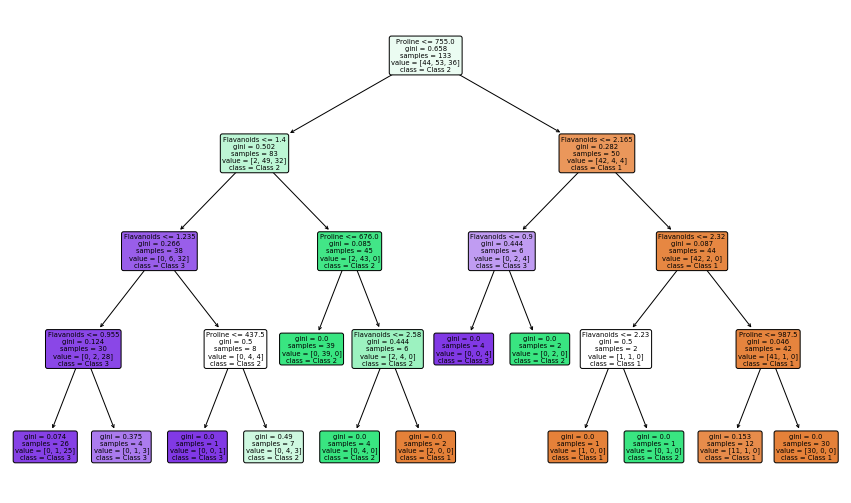

In [17]:
fig, ax = plt.subplots(figsize=(15,9)) # initialise the plots and axes
# plot the decision tree for the model df_dtc
plot_tree(df_dtc, 
 filled = True, # colour the nodes according to the classifaction
 rounded = True, # make the nodes have rounded corners
 class_names = ['Class 1', 'Class 2','Class 3'], # use these names for targets
 feature_names = X.columns # use these names for features
 );

## Overfitting

Decision trees could continue the branching process until there is only one sample for each leaf and the depth of the tree is very large. However, this will typically lead to the variance of the model also being very large and the model being extremely sensitive to the training set. Recall that this is the characteristic of model overfitting. 

As we changed the maximum depth of the decision tree above the maximum accuracy on the testing set occured when `max_depth=3`, and this decreased significantly for `max_depth=4`. We can investigate what occurs if we don't specify the maximum depth. In this case the tree has 8 levels and the accuracy decreases dramatically to 82.2%. It can also be observed that some of the decision boundaries will be very sensitive to the choice of the training set. In particular the thin regions at $x=0.6$, $200 \lt y \lt 500$ and $2.25 \lt x \lt 3$, $y=1000$ are the result of one point in these regions. If each of these points were removed, the regions would also disappear.

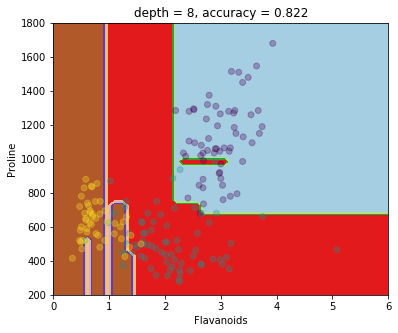

In [18]:
# fit the data to our DTC
df_dtc = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(6,5)) # initialise the plots and axes
plt_decision_boundaries(df_dtc,xx,yy) # contour plot of the decision boundaries for this classifier
# scatter plot of the two features, coloured based on the target, alpha set the transperancy
plt.scatter(X['Flavanoids'], X['Proline'], c=y, alpha=0.3);
depth = df_dtc.tree_.max_depth # find the maximum depth of the decision tree
Y_pred = df_dtc.predict(X_test) # obtain the predicted values
accuracy = np.round(accuracy_score(y_test, Y_pred),3) # calculate the accuracy score
# add the depth and accuracy to the title
plt.title('depth = {0}, accuracy = {1}'.format(depth,accuracy))
plt.xlabel('Flavanoids') # xlabel
plt.ylabel('Proline'); # ylabel

One way to combat this problem of overfitting is to use cross-validation and use the accuracy score to search for the optimal value of the tree depth. A number of other hyperparameters could also be used to search for the optimal accuracy. For example, `min_samples_leaf` specifies the minimum number of samples that a node must have to qualify as a leaf. Increasing this removes small regions as in the figure above. If we set this equal to four and do not limit the depth of the tree, we can obtain an accuracy of 93.3%, as seen below. For other parameters see the documentation for the Decision Tree Classifier (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

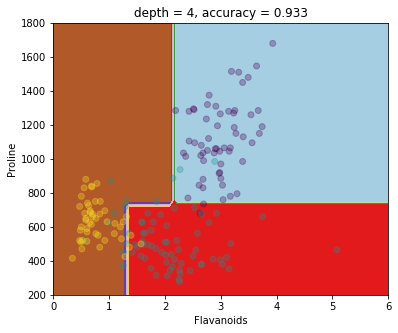

In [19]:
# fit the data to our DTC, specifying the minimum number of samples that a leaf must have
df_dtc = DecisionTreeClassifier(random_state = 42, min_samples_leaf=4, max_depth=4).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(6,5)) # initialise the plots and axes
plt_decision_boundaries(df_dtc,xx,yy) # contour plot of the decision boundaries for this classifier
# scatter plot of the two features, coloured based on the target, alpha set the transperancy
plt.scatter(X['Flavanoids'], X['Proline'], c=y, alpha=0.3);
depth = df_dtc.tree_.max_depth # find the maximum depth of the decision tree
Y_pred = df_dtc.predict(X_test) # obtain the predicted values
accuracy = np.round(accuracy_score(y_test, Y_pred),3) # calculate the accuracy score
# add the depth and accuracy to the title
plt.title('depth = {0}, accuracy = {1}'.format(depth,accuracy))
plt.xlabel('Flavanoids') # xlabel
plt.ylabel('Proline'); # ylabel

As noted above decision trees are very sensitive to the choice of training set, however it is relatively cheap to create a single decision tree. Therefore, in general the technique for combatting overfitting in decision trees is to run an ensemble of decision trees with random training sets and use these to create an averaged classifier. This is the basis of the Random Forest Classifier. The advantage of this technique is that the averaged classifier will often give better accurary than any of the members of the ensemble. We will consider Random Forest Classifiers in the next lesson.

## Exercises

For these exercises we will model a dataset of the properties of wheat seeds. This is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/seeds). Make sure you copy the text file to your working directory. The seedtype is an integer corresponding to the three classes in the cell below.

In [20]:
seeds = pd.read_csv('seeds_dataset.csv', header=None, 
                   names=['area','perimeter','compactness','length','width','asymmetry',
                         'groovelength','seedtype'])
classes = ['Kama', 'Rosa', 'Canadian']

### Exercise 1

Split the data into features and labels, and into a training and testing set. (2 marks)

In [21]:
# Split the data into features and labels
x_seeds = seeds.drop('seedtype', axis=1)
y_seeds = seeds['seedtype']

# Split the data into training and testing sets
x_train_seeds, x_test_seeds, y_train_seeds, y_test_seeds = train_test_split(x_seeds, y_seeds, random_state=42)


### Exercise 2

Create a simple Decision Tree of maximum depth=3 and fit the training data to this model. (2 marks)

In [25]:
# Create a simple Decision Tree of maximum depth=3 and fit the training data to this model
dtc_seeds_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dtc_seeds_model.fit(x_train_seeds, y_train_seeds)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### Exercise 3

Plot the decision tree for this model, and identify the most significant features for the classification of this dataset. (2 marks)

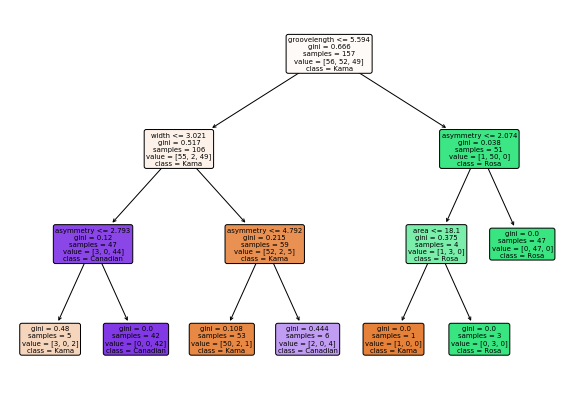

In [26]:
# Plot the decision tree for this model
plt.figure(figsize=(10, 7))
plot_tree(dtc_seeds, filled=True, rounded=True, class_names=classes, feature_names=x_seeds.columns)
plt.show()


Most important features are:

### Exercise 4

Plot the confusion matrix for this model, and calculate the accuracy. (2 marks)

Accuracy: 0.8867924528301887


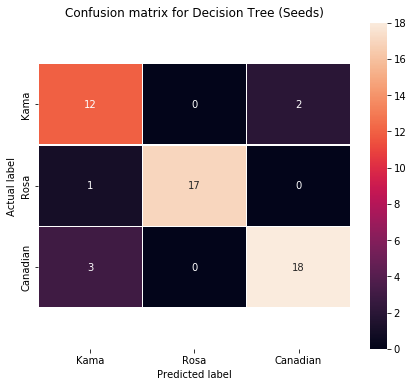

In [27]:
# Plot the confusion matrix for this model
y_pred_seeds = dtc_seeds.predict(x_test_seeds)
model_seeds = confusion_matrix(y_test_seeds, y_pred_seeds)
plt_confusion_matrix(model_seeds, classes, 'Decision Tree (Seeds)')
accuracy_seeds = accuracy_score(y_test_seeds, y_pred_seeds)
print("Accuracy:", accuracy_seeds)


### Exercise 5

Vary the maximum depth to find the optimal accuracy of this model. You should be able to achieve an accuracy of approximately 91%. (2 marks)

Optimal Depth: 4
Optimal Accuracy: 0.9056603773584906


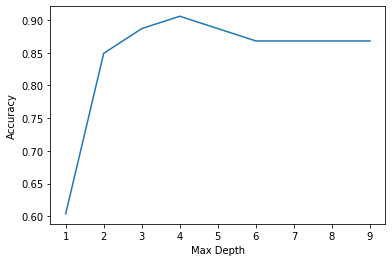

In [28]:
# Vary the maximum depth to find the optimal accuracy of this model
max_depths = range(1, 10)
list_of_accuracies = []

for depth in max_depths:
    dtc_seeds = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dtc_seeds.fit(x_train_seeds, y_train_seeds)
    y_pred_seeds1 = dtc_seeds.predict(x_test_seeds)
    accuracy = accuracy_score(y_test_seeds, y_pred_seeds1)
    list_of_accuracies.append(accuracy)

optimal_depth = max_depths[np.argmax(list_of_accuracies)]
optimal_accuracy = max(list_of_accuracies)
print("Optimal Depth:", optimal_depth)
print("Optimal Accuracy:", optimal_accuracy)

plt.plot(max_depths, list_of_accuracies)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()


yes the optimal accuracy is almost 0.91 i.e 91%